In [248]:
import numpy as np
import gym
from gym import spaces
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
import io


'''
This is the environment currently used for continuous MWM task

'''

MAX_MARCH = 20
EPSILON = 0.1
DEG_TO_RAD = 0.0174533
WINDOW_SIZE = (300, 300) # Width x Height in pixels
MAX_LEN = np.linalg.norm(WINDOW_SIZE)

object_to_idx = {
    'wall': 1,
    'goal': 2
}
color_to_idx = {
    'invisible': 0,
    'red': 1,
    'green': 2,
    'blue': 3,
    'yellow': 4,
    'purple': 5,
    'white': 6
}
# idx_to_rgb = {
#     1: np.array([230, 0, 0]),
#     2: np.array([0, 230, 0]),
#     3: np.array([0, 0, 230]),
#     4: np.array([230, 230, 0]),
#     5: np.array([230, 0, 230]),
#     6: np.array([230, 230, 230])
# }
idx_to_rgb = {
    0: np.array([0.6, 0.6, 0.6]),
    1: np.array([0.9, 0, 0]),
    2: np.array([0, 0.9, 0]),
    3: np.array([0, 0, 0.9]),
    4: np.array([0.9, 0.9, 0]),
    5: np.array([0.9, 0, 0.9]),
    6: np.array([0.9, 0.9, 0.9])
}


    

    
def block_view_world(character, block_size=25, randomize_heading=0):
    '''
    Create a setting where the goal is perfectly blocked by a block
    randomize_heading:
        0 - always fixed
        1 - randomize headings but point agent in the right direction
        2 - randomize headings and point agent in random direction
    '''
#     print('call block view world')
    
    reset_objects()
    
    boxes, box_centers, box_sizes = generate_boxes(0)
    circles, circle_centers, circle_radii = generate_circles(0)
    
    #add a single block in the center of the screen
    add_box(Box(np.array([WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2]),
               np.array([block_size, block_size]), color=2))
    add_walls()
    
    base_size = 15
    base_x = 150
    base_y = 100
    base_radius = 88
    if randomize_heading > 0:
        angle = np.random.uniform(6.28)
        x = np.cos(angle) * base_radius
        y = np.sin(angle) * base_radius
        goal = Box(np.array([x + base_x, y + base_y]), np.array([base_size, base_size]), 
            is_goal=True, color=6)
        globals()['goal'] = goal
        add_box(goal)
        
        angle2 = angle + 3.14
        x = np.cos(angle2) * base_radius
        y = np.sin(angle2) * base_radius
        character.pos = np.array([x + base_x, y + base_y])
        
        if randomize_heading > 1:
            character.angle = np.random.uniform(6.28)
        else:
            character.angle = angle
            
        character.update_rays()
        
    else:
        #add the goal
        goal = Box(np.array([WINDOW_SIZE[0] - 50, WINDOW_SIZE[1]/2]),
                   np.array([base_size, base_size]),
                   is_goal=True, color=6)
        globals()['goal'] = goal
        add_box(goal)

        #set the agent position
        character.pos = np.array([50, WINDOW_SIZE[1]/2])
        character.angle = 0
        
        character.update_rays()



def dist(v):
    '''calculate length of vector'''
    return np.linalg.norm(v)



        
def randomize_location_and_angle(character, sep=True):
    '''
    create a random location and start direction for the character
    noting that we do not allow spawning into objects
    sep: if set to True, we will make sure character has a minimum distance away
        from the goal that is at least half the max distance possible from goal
        to end of window
    '''

    #max distance from goal to end of window
    max_goal_sep = dist(np.max([np.array(WINDOW_SIZE) - goal.center, goal.center], axis=0)) 
    sep = True
    searching = True
    while searching:
        pos = np.random.uniform(WINDOW_SIZE)
        goal_sep = dist(globals()['goal'].center - pos)

        if scene_sdf(pos)[0] > 0 and (not sep or goal_sep > max_goal_sep / 2):
            #position is okay
            searching = False
            
    character.pos = pos
    character.angle = np.random.uniform(6.28)
#     character.pos = np.array([100, 100])
#     character.angle = 0

    character.update_rays()




















class Character:
    def __init__(self, pos=[WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2], angle=0, color=4, size=10,
                fov=120*DEG_TO_RAD, num_rays=30, render_rays=True):
        '''
        Generate a character that can move through the window
        pos: starting position
        angle: starting angle (radians) angle always takes on values from -pi to pi
        color: color
        size: size
        fov: range of angles character can see using rays
        num_rays: fidelity of depth perception
        draw_rays: whether or not to draw the characters rays
        '''
        self.pos = pos
        self.angle = (angle + np.pi) % (2*np.pi) - np.pi
        self.color = color
        self.size = size
        self.fov = fov
        self.ray_splits = fov / num_rays
        self.render_rays = render_rays
        self.num_rays = num_rays
        
        self.rays = []
        
        fov_start = self.angle - self.fov/2
        for i in range(num_rays):
            self.rays.append(Ray(self.pos, fov_start + i*self.ray_splits))
    
    
    def update_rays(self, vis_walls=[], vis_wall_refs=[]):
        '''
        update the angle of the rays using own position and angle
        '''
        fov_start = self.angle - self.fov/2
        for i in range(self.num_rays):
            self.rays[i].update(start=self.pos, angle=fov_start + i*self.ray_splits, vis_walls=vis_walls, vis_wall_refs=vis_wall_refs)
            
            
    def draw_rays(self):
        '''
        draw the rays coming from character
        '''
        for ray in self.rays:
            ray.draw()
        
    
    def draw(self):
        '''
        draw the character
        '''
        angle1 = self.angle - 0.3
        angle2 = self.angle + 0.3
        point1 = [self.pos[0], self.pos[1]]
        point2 = [self.pos[0] - math.cos(angle1)*self.size, self.pos[1] - math.sin(angle1)*self.size]
        point3 = [self.pos[0] - math.cos(angle2)*self.size, self.pos[1] - math.sin(angle2)*self.size]

        draw_color = idx_to_rgb[self.color]
        
        poly = plt.Polygon([point1, point2, point3], fc=draw_color)
        plt.gca().add_patch(poly)

        
        if self.render_rays:
            self.draw_rays()
        
        
    def move(self, speed, col_walls, col_wall_refs, vis_walls, vis_wall_refs):
        '''
        move in the faced direction with number of pixels of speed
        collision detection uses the same ray marching algorithm
        after moving, update the rays
        
        Note we have to pass the walls that can be collided with for movement
        '''
        start = self.pos
        end = [self.pos[0] + math.cos(self.angle) * speed, self.pos[1] + math.sin(self.angle) * speed]
        
        min_dist, collision_obj = self.march(start, end, col_walls, col_wall_refs)

        if collision_obj == None:
            self.pos[0] += math.cos(self.angle) * speed
            self.pos[1] += math.sin(self.angle) * speed
            
        else:
            self.pos[0] += math.cos(self.angle) * (min_dist - speed * 0.1)
            self.pos[1] += math.sin(self.angle) * (min_dist - speed * 0.1)
        self.update_rays(vis_walls, vis_wall_refs)

        return collision_obj
            
            
    def march(self, start, end, col_walls, col_wall_refs):
        '''
        perform ray march, find collision with col_walls
        '''
        intersects = []
        for col_wall in col_walls:
            intersects.append(intersect(start, end, col_wall[0], col_wall[1]))
        min_dist = np.inf
        min_idx = None
        for idx, inter in enumerate(intersects):
            if inter != None:
                d = dist((inter[0]-start[0], inter[1]-start[1]))
                if d < min_dist:
                    min_dist = d
                    min_idx = idx
        
        if min_idx == None:
            return min_dist, min_idx
        else:
            return min_dist, col_wall_refs[min_idx]
    
        
    def rotate(self, angle, vis_walls, vis_wall_refs):
        self.angle += angle
        self.angle = (self.angle + np.pi) % (2*np.pi) - np.pi
        self.update_rays(vis_walls=vis_walls, vis_wall_refs=vis_wall_refs)
        
    
    def ray_obs(self, max_depth=MAX_LEN):
        '''
        Get all rays and their distances to objects
        normalize_depth: divide depth readings by value 
        '''
        ray_colors = []
        ray_depths = []
        for ray in self.rays:
            ray_colors.append(ray.touched_obj.color)
            ray_depths.append(ray.obj_dist)

        ray_colors = np.array(ray_colors) / 6
        ray_depths = np.array(ray_depths) / max_depth
        visual = np.append(ray_colors, ray_depths)
        return visual







class Box():
    def __init__(self, corner, size, color=1, is_goal=False):
        self.size = size #this is a size 2 array for length and height
        self.color = color
        self.is_goal = is_goal
        self.corner = corner
        self.center = [self.corner[0] + self.size[0]/2, self.corner[1] + self.size[1]/2]
        
            
    def draw(self, ax=None):
        rect = plt.Rectangle(self.corner, self.size[0], self.size[1], fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        
    def get_walls(self):
        walls = [
                 [(self.corner[0], self.corner[1]), (self.corner[0], self.corner[1]+self.size[1])], #bl to ul
                 [(self.corner[0], self.corner[1]), (self.corner[0]+self.size[0], self.corner[1])], #bl to br
                 [(self.corner[0], self.corner[1]+self.size[1]), (self.corner[0]+self.size[0], self.corner[1]+self.size[1])], #ul to ur
                 [(self.corner[0]+self.size[0], self.corner[1]), (self.corner[0]+self.size[0], self.corner[1]+self.size[1])], #br to ur
                ]
        return walls






class Ray():
    def __init__(self, start, angle, color=6):
        '''
        Ray for ray marching
        if render_march is True, then we render the sdf circles used to calculate march 
        '''
        self.start = start
        self.angle = angle
        self.color = color
        self.touched_obj = None
        self.obj_dist = MAX_LEN
        
        
    def update(self, start=None, angle=None, vis_walls=[], vis_wall_refs=[]):
        '''
        update position and angle, perform march, determine object and distance
        '''
        if start is not None:
            self.start = start
        if angle is not None:
            self.angle = angle
        self.obj_dist, self.touched_obj = self.march(vis_walls, vis_wall_refs)
        
                
    def march(self, vis_walls, vis_wall_refs):
        '''
        perform ray march, find collision with object
        '''
        end = self.start + np.array([np.cos(self.angle), np.sin(self.angle)]) * MAX_LEN
        # print(end)
        intersects = []
        for vis_wall in vis_walls:
            intersects.append(intersect(self.start, end, vis_wall[0], vis_wall[1]))
        
        min_dist = np.inf
        min_idx = 0
        for idx, inter in enumerate(intersects):
            if inter != None:
                d = dist((inter[0]-self.start[0], inter[1]-self.start[1]))
                if d < min_dist:
                    min_dist = d
                    min_idx = idx
        # print(min_dist)
        if min_idx == None:
            return min_dist, min_idx
        else:
            return min_dist, vis_wall_refs[min_idx]
    
    def draw(self):
        rect = plt.Rectangle(self.start, self.obj_dist, 1, self.angle * 180 / np.pi, fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        plt.gca().add_patch(rect)
        # plt.scatter([self.start[0]+self.obj_dist*math.cos(self.angle)], [self.start[1]+self.obj_dist*math.sin(self.angle)])
        
            
            
            

def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)




class NavEnvFlat(gym.Env):
    metadata = {"render.modes": ['rgb_array', 'human'], 'video.frames_per_second': 24}
    def __init__(self, num_rays=30, max_steps=200, num_objects=5,
                rew_structure='dist', give_heading=0, verbose=0,
                world_gen_func=None, world_gen_params={}, give_dist=True,
                give_time=False, collission_penalty=0, default_reward=0,
                sub_goal_reward=0.01, goal_visible=True, wall_colors=1,
                task_structure=1, poster=False, auxiliary_tasks=[],
                auxiliary_task_args=[]):
        '''
        rew_structure: 'dist' - reward given based on distance to goal
                        'goal' - reward only given when goal reached
        give_heading: whether to additionally give a distance and direction to goal
        flat: whether to give observations in a flattened state
        world_gen_func: a function can be passed to manually create a world
            using some other rules. Note that it needs to generate objects, a goal, and
            set the agent position and heading
            The character will be passed as the argument
        wall_colors: 
            1: red, red, red, red
            2: red, green, red, green
            2.5: red, red, green, green
            4: red, green, blue, purple
        task_structure:
            1: visible goal, randomize position
            2: invisible goal, fixed position
        poster:
            whether there should be a poster and on which wall [0-3]
        auxiliary_tasks: (pass as list of tasks desired)
            'null': task to output constant 0
            'euclidean_start': task to output euclidean distance travelled from start of episode
            'wall_direction': task to output relative degrees required to face a certain wall
        auxiliary_task_args: (pass as a list of arguments)
            'null': None (might later implement task to output n values)
            'euclidean_start': None
            'wall_direction': 1 (default), 2, 3, or 4 - pass wall that should be faced (east is 1, ccw)
        '''
        super(NavEnvFlat, self).__init__()

        #this gives the auxiliary tasks available and dimension of output
        available_auxiliary_tasks = {
            'null': 1,
            'euclidean_start': 1,
            'wall_direction': 1
        }
        auxiliary_task_to_idx = {
            'null': 0,
            'euclidean_start': 1,
            'wall_direction': 2
        }
        
        self.total_rewards = 0
        self.give_dist = give_dist
        self.give_heading = give_heading
        self.give_time = give_time
        self.collission_penalty = collission_penalty
        self.default_reward = default_reward
        self.sub_goal_reward = sub_goal_reward
        self.rew_structure = rew_structure
        self.task_structure = task_structure
        self.verbose = verbose
        self.world_gen_func = world_gen_func
        self.world_gen_params = world_gen_params
        self.wall_colors = wall_colors
        self.goal_visible = goal_visible # Note: not used, visibility defined by
                                         # task structure at the moment
        self.poster = poster

        observation_width = num_rays
        if give_dist:
            observation_width = observation_width * 2
        if give_heading:
            observation_width += 1
        if give_time:
            observation_width += 1

        self.observation_space = spaces.Box(low=0, high=6, shape=(observation_width,))
        self.action_space = spaces.Discrete(4) #turn left, forward, right as actions
        
        self.max_steps = max_steps
        self.current_steps = 0
        
        self.character = Character()
        self.initial_character_position = self.character.pos.copy()
        self.num_objects = num_objects
        
        self.fig = None
        
        self.vis_walls = []
        self.vis_wall_refs = []
        self.col_walls = []
        self.col_wall_refs = []


        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        self.auxiliary_tasks = []
        self.auxiliary_task_args = auxiliary_task_args
        for task in auxiliary_tasks:
            if type(task) == int:
                self.auxiliary_tasks.append(task)
            elif task not in available_auxiliary_tasks.keys():
                raise NotImplementedError('Auxiliary task {} not found. Available options are '.format(
                    task, ', '.join(available_auxiliary_tasks.keys())))
            else:
                self.auxiliary_tasks.append(auxiliary_task_to_idx[task])
        
        # self.auxiliary_tasks = [auxiliary_task_to_idx[task] for task in auxiliary_tasks]
        # print('auxiliary tasks', self.auxiliary_tasks)
        
    def step(self, action):
        reward = self.default_reward
        collision_obj = None
        done = False
        info = {}
        
        if action == 0:
            self.character.rotate(-0.2, self.vis_walls, self.vis_wall_refs)
        if action == 1:
            collision_obj = self.character.move(10, self.col_walls, self.col_wall_refs,
                                self.vis_walls, self.vis_wall_refs)
        if action == 2:
            self.character.rotate(0.2, self.vis_walls, self.vis_wall_refs)
        if action == 3:
            pass

        if self.rew_structure == 'dist':
            goal = self.boxes[-1]
            dist_to_goal = self.sub_goal_reward * \
                (MAX_LEN-dist(goal.center - self.character.pos)) / MAX_LEN
            reward = float(dist_to_goal)

            
        if collision_obj != None:
            if collision_obj.is_goal:
                if self.verbose:
                    print('goal reached!')
                reward = float(1)
                done = True
            else:
#                 reward = -10
                reward = float(self.collission_penalty)
        
        
        observation = self.get_observation()
        auxiliary_output = self.get_auxiliary_output()
        info['auxiliary'] = auxiliary_output
        
        if self.current_steps > self.max_steps:
            done = True
        
        self.current_steps += 1
        self.total_rewards += reward
        if done and self.verbose:
            print('done, total_reward:{}'.format(self.total_rewards))
        return observation, reward, done, info
    

    def reset(self):
        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        self.character.update_rays(self.vis_walls, self.vis_wall_refs)
        observation = self.get_observation()
        self.initial_character_position = self.character.pos.copy()
        self.current_steps = 0
        self.total_rewards = 0
        return observation

    
    def render(self, mode='rgb_array'):
        plt.style.use('dark_background')
        fig = plt.figure(figsize=(6,6))
        plt.xlim([0, WINDOW_SIZE[0]])
        plt.ylim([0, WINDOW_SIZE[1]])

        self.character.draw()
        for box in self.boxes:
            box.draw()

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        #trim borders
        # image_from_plot = image_from_plot[52:380,52:390,:]
        
        # with io.BytesIO() as buff:
        #     fig.savefig(buff, format='raw')
        #     buff.seek(0)
        #     data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
        # w, h = fig.canvas.get_width_height()
        # im = data.reshape((int(h), int(w), -1))
        
        if mode == 'human':
            plt.show()
            
        if mode == 'rgb_array':
            plt.close()
            return image_from_plot
            
            # return im
            
        
    def get_observation(self):
#         ray_depths, ray_colors = self.character.ray_obs()
#         return np.append(ray_depths, ray_colors)

        if self.give_heading > 0:
            raise NotImplementedError('Have not adjusted give_heading code')
            #tell where the goal is distance and heading
            ray_obs = self.character.ray_obs()
            goal = objects[-1]
            dist_to_goal = np.clip(dist(goal.center - self.character.pos), 0, 1000) / 1000
            heading = goal.center - self.character.pos
            heading = np.arctan2(heading[1], heading[0])

            if self.give_heading == 1:
                #only give distance to goal
                obs = np.vstack([ray_obs, [dist_to_goal, 0, 0]])
            elif self.give_heading == 2:
                #give distance and angle to goal
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, 0]])
            elif self.give_heading == 3:
                #give distance and angle to goal and current agent angle
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, self.character.angle]])
            
                        
            return np.array(obs.reshape(-1), dtype='float')
            
        else:
            obs = self.character.ray_obs()
            if not self.give_dist:
                obs = obs[:self.num_rays]

            return np.array(self.character.ray_obs().reshape(-1), dtype='float')
        
    def get_auxiliary_output(self):
        '''Return the auxiliary output dependent on what tasks are being measured'''
                
        auxiliary_output = []
        
        for i in range(len(self.auxiliary_tasks)):
        # for i, task in self.auxiliary_tasks:
            task = self.auxiliary_tasks[i]
            if i >= len(self.auxiliary_task_args):
                aux_arg = None
            else:
                aux_arg = self.auxiliary_task_args[i]
            #null task - predict 0
            if task == 0:
                output = [0]
                auxiliary_output += output
            #euclidean distance from start task (normalized)
            if task == 1:
                euclid_dist_start = dist(self.character.pos - self.initial_character_position)
                euclid_dist_start = euclid_dist_start / MAX_LEN
                output = [euclid_dist_start]
                auxiliary_output += output
            #relative angle from wall, depending on arg passed
            if task == 2:
                if aux_arg == None:
                    wall = 0
                else:
                    wall = aux_arg - 1
                if wall < 0 or wall > 3:
                    raise Exception('Invalid wall number passed for relative wall direction auxiliary' + \
                        'task. Must use an integer between 1 and 4, or None')
                
                if wall > 2:
                    wall = wall - 4
                wall_angle = (wall * 0.5) * np.pi
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                
                min_rel_angle = np.min([abs(wall_angle - char_2pi_angle), 
                                        abs(wall_angle + 2*np.pi - char_2pi_angle)])
                output = [min_rel_angle]
                auxiliary_output += output
                
                
        return np.array(auxiliary_output)
    
        

    def generate_world(self):
        self.boxes, walls, wall_refs = self.make_walls()

        if self.task_structure == 1:
            #generate a visible goal with random position
            corner = np.random.uniform(low=30, high=270, size=(2,))
            goal = Box(corner, [20, 20], color=6, is_goal=True)
            goal_walls, goal_wall_refs = self.get_walls([goal])
            self.vis_walls, self.vis_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            self.boxes.append(goal)

            # if self.goal_visible:
            #     self.vis_walls, self.vis_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            #     self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            # else:
            #     self.vis_walls, self.vis_wall_refs = walls, wall_refs
            #     self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            # self.boxes.append(goal)
        elif self.task_structure == 2:
            corner = np.array([240, 60])
            goal = Box(corner, [20, 20], color=0, is_goal=True)            
            goal_walls, goal_wall_refs = self.get_walls([goal])
            self.vis_walls, self.vis_wall_refs = walls, wall_refs
            self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            self.boxes.append(goal)

        #generate character which must be at least some distance from the goal
        searching = True
        while searching:
            pos = np.random.uniform(low=30, high=270, size=(2,))
            if dist(corner - pos) > 50:
                searching = False
        angle = np.random.uniform(0, 2*np.pi)
        self.character = Character(pos, angle)



    def make_walls(self, thickness=1):
        boxes = []
        y = WINDOW_SIZE[1]
        x = WINDOW_SIZE[0]
        thickness = 5

        walls = []
        if self.wall_colors == 1:
            walls = ['red', 'red', 'red', 'red']
        elif self.wall_colors == 2:
            walls = ['red', 'green', 'red', 'green']
        elif self.wall_colors == 2.5:
            walls = ['red', 'red', 'green', 'green']
        elif self.wall_colors == 3:
            walls = ['red', 'green', 'red', 'blue']
        elif self.wall_colors == 3.5:
            walls = ['red', 'red', 'green', 'blue']
        elif self.wall_colors == 4:
            walls = ['red', 'green', 'blue', 'purple']
        wall_colors = [color_to_idx[color] for color in walls]


        boxes.append(Box(np.array([0, 0]), np.array([thickness, y]), color=wall_colors[2]))
        boxes.append(Box(np.array([0, 0]), np.array([x, thickness]), color=wall_colors[3]))
        boxes.append(Box(np.array([0, y-thickness]), np.array([x, thickness]), color=wall_colors[1]))
        boxes.append(Box(np.array([x-thickness, 0]), np.array([thickness, y]), color=wall_colors[0]))
        


        # manually create walls here so that we don't need to check more walls than necessary
        # on intersections
        walls = [
            [[thickness, 0], [thickness, y]],
            [[0, thickness], [x, thickness]],
            [[0, y-thickness], [x, y-thickness]],
            [[x-thickness, 0], [x-thickness, y]]
        ]
        wall_refs = [
            boxes[0],
            boxes[1],
            boxes[2],
            boxes[3]
        ]


        # add poster
        if self.poster is not False:
            p_thickness = thickness + 1
            p_length = 50
            p_half = 25
            midpoint = 300 / 2
            color = color_to_idx['yellow']
            if self.poster == 0:
                boxes.append(Box(np.array([x-p_thickness, midpoint-p_half]),
                                 np.array([p_thickness, p_length]), color=color))
                intersect = [[x-p_thickness, midpoint-p_half], [x-p_thickness, midpoint+p_half]]
            elif self.poster == 1:
                boxes.append(Box(np.array([midpoint-p_half, y-p_thickness]),
                                 np.array([p_length, p_thickness]), color=color))
                intersect = [[midpoint-p_half, y-p_thickness], [midpoint+p_half, y-p_thickness]]
            elif self.poster == 2:
                boxes.append(Box(np.array([0, midpoint-p_half]),
                                 np.array([p_thickness, p_length]), color=color))
                intersect = [[p_thickness, midpoint-p_half], [p_thickness, midpoint+p_half]]
            elif self.poster == 3:
                boxes.append(Box(np.array([midpoint-p_half, 0]),
                                 np.array([p_length, p_thickness]), color=color))
                intersect = [[midpoint-p_half, p_thickness], [midpoint+p_half, p_thickness]]

            walls.append(intersect)
            wall_refs.append(boxes[4])

        
        return boxes, walls, wall_refs
        
    def get_walls(self, boxes):
        '''
        Get tuples of points to intersect with for rays from a list of boxes
        '''
        walls = []
        wall_refs = []
        for box in boxes:
            walls = walls + box.get_walls()
            wall_refs = wall_refs + [box] * 4
        return walls, wall_refs


    def seed(self, seed=0):
        np.random.seed(seed)


In [28]:
MAX_LEN

424.26406871192853

In [121]:
a = [1, 2, 3, 4, 5]

In [125]:
a[:10]

[1, 2, 3, 4, 5]

In [74]:
env = NavEnvFlat(auxiliary_tasks=['euclidean_start'])
env.reset()

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.5852165 , 0.59490178, 0.60792463, 0.6246417 , 0.64553809,
       0.6712645 , 0.68043255, 0.62063073, 0.57305775, 0.53467816,
       0.50341535, 0.47780571, 0.45679327, 0.43960259, 0.42565742,
       0.41452723, 0.40589135, 0.39951463, 0.39523091, 0.39293211,
       0.39256135, 0.39410954, 0.3976148 , 0.40316479, 0.36981842,
       0.3024964 , 0.25696942, 0.22430358, 0.19986994, 0.18103191])

In [120]:
env.step(1)

(array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 1.        , 1.        , 1.        ,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.37862707, 0.38744609, 0.39867436, 0.4126432 , 0.42979643,
        0.45072876, 0.47624339, 0.32786067, 0.30664605, 0.31214284,
        0.65422009, 0.68017201, 0.65562495, 0.6357775 , 0.62002838,
        0.60793084, 0.59915952, 0.593488  , 0.59077405, 0.59095076,
        0.59402247, 0.600065  , 0.60923035, 0.62175614, 0.63798123,
        0.65836927, 0.63534739, 0.56869632, 0.51698113, 0.47601329]),
 0.006686971146799975,
 False,
 {},
 array([0.07429461]))

In [67]:
env.get_auxiliary_output()

[0.0906182118191957]

In [38]:
env.character.pos.copy()

array([79.12335538, 34.86611887])

In [ ]:
env.

In [ ]:
env

In [22]:
env.auxiliary_tasks

[0]

In [18]:
env.initial_character_position

array([130.11010809, 201.99317764])

In [17]:
env.reset()

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.36486215, 0.34802126, 0.33422289, 0.32299051, 0.31396846,
       0.30689126, 0.30156287, 0.29784265, 0.29563586, 0.29488763,
       0.29557957, 0.29772869, 0.30138837, 0.30665172, 0.31365744,
       0.32259916, 0.33373932, 0.34742958, 0.36414101, 0.38450926,
       0.40940388, 0.44003742, 0.47814388, 0.52628307, 0.53656967,
       0.51694405, 0.50105841, 0.48842862, 0.47869469, 0.47159382])

In [10]:
char.pos

[150.0, 150.0]

In [321]:
env = NavEnvFlat(auxiliary_tasks=[2], auxiliary_task_args=[4],
                task_structure=2)

env.reset()

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.54226888, 0.58082543, 0.56031886, 0.54376977, 0.53068146,
       0.5206855 , 0.51351469, 0.50898474, 0.50698239, 0.50745833,
       0.51042425, 0.51595348, 0.52418558, 0.535335  , 0.54970534,
       0.5677106 , 0.58990658, 0.61703726, 0.61701543, 0.56898329,
       0.53028616, 0.49879283, 0.47300578, 0.45184713, 0.43452671,
       0.42045795, 0.4092027 , 0.40043434, 0.39391272, 0.38946716])

(array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.2441143 , 0.26219272, 0.28466072, 0.31300819, 0.34440359,
       0.33165833, 0.32133236, 0.31310934, 0.30675386, 0.30209375,
       0.29900805, 0.2974191 , 0.29728765, 0.29861047, 0.30142017,
       0.30578716, 0.31182406, 0.319693  , 0.32961681, 0.34189551,
       0.35693061, 0.37526124, 0.39761861, 0.42501056, 0.45885671,
       0.50121319, 0.55516443, 0.57601069, 0.55641246, 0.5406513 ]), 0.005741306922854293, False, {'auxiliary': array([0.23801651])})


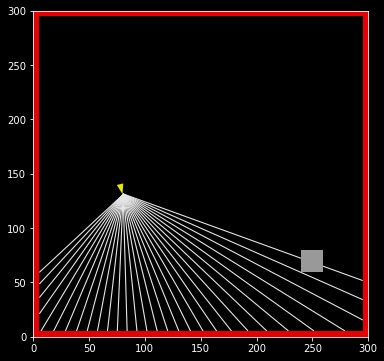

In [330]:
print(env.step(0))

env.render('human')

In [47]:
env.step(2)
print(env.character.angle)

-2.100012038269619


In [105]:
wall_angle

1.5707963267948966

In [106]:
char_2pi_angle

5.699987961730385

2.1539936722440975

1.4999879617303833

0.8840614258324733
2.25753122775732


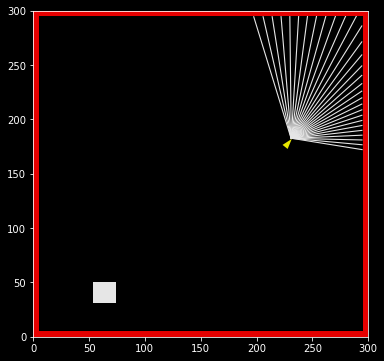

In [241]:
env.step(2)
print((env.character.angle + 2 * np.pi) % (2 * np.pi))
wall_angle = 1 * np.pi
char_2pi_angle = (env.character.angle + 2 * np.pi) % (2 * np.pi) 

print(
env.render('human')